Import data from Data Cleaning output

In [451]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix


pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [452]:
df = pd.read_csv("C:/Users/Owner/Desktop/AlaskaProject/Data/modeldata.csv")
df.columns

Index(['participant.code', 'question', 'choice_binary', 'rowA_', 'rowB_',
       'rowdiff', 'price_diff', 'price_diff_rel', 'legroom_diff',
       'bathroom_dist_diff', 'distance_', 'price_', 'height',
       'colA_categorical_Aisle', 'colA_categorical_Middle',
       'colA_categorical_Window', 'colB_categorical_Aisle',
       'colB_categorical_Middle', 'colB_categorical_Window',
       'seatA_class_Bathroom', 'seatA_class_Economy', 'seatA_class_ExitRow',
       'seatA_class_First', 'seatA_class_Premium', 'seatB_class_Bathroom',
       'seatB_class_Economy', 'seatB_class_ExitRow', 'seatB_class_First',
       'seatB_class_Premium', 'plane_sideA_Left', 'plane_sideA_Right',
       'plane_sideB_Left', 'plane_sideB_Right', 'time__Daytime',
       'time__Red-eye', 'flyerfreq_nonflyer', 'flyerfreq_typical',
       'flyerfreq_frequent', 'flyertype_leisure', 'flyertype_business',
       'hours_short', 'hours_typical', 'hours_long', 'gender_Female',
       'gender_Male', 'gender_Not Specified', 

Column Cleanup

In [453]:
df.drop(['participant.code','question'],inplace = True, axis = 1)
df.rename(columns={'time__Red-eye':'time_redeye'}, inplace=True)

Define variables and train/test split

In [454]:
df_train = df.sample(frac = 0.8, random_state = 42)
df_test = df.drop(df_train.index)

Scale continuous variables

In [435]:
# Scaled Variables
#Legroom
#df_train["legroom_diff"] = preprocessing.scale(pd.to_numeric(df_train["legroom_diff"]))
#df_test["legroom_diff"] = preprocessing.scale(pd.to_numeric(df_test["legroom_diff"]))
#df["legroom_diff"] = preprocessing.scale(pd.to_numeric(df["legroom_diff"]))

#Variable Price
df_train["price_diff"] = preprocessing.scale(pd.to_numeric(df_train["price_diff"]))
df_test["price_diff"] = preprocessing.scale(pd.to_numeric(df_test["price_diff"]))
df["price_diff"] = preprocessing.scale(pd.to_numeric(df["price_diff"]))


Define Y and Features

In [284]:
# Define output variable
y_dftrain = df_train.choice_binary
# Drop output variable from dataset to form input vector
X_dftrain = df_train.drop('choice_binary', axis=1)

# Define output variable
y_dftest = df_test.choice_binary
# Drop output variable from dataset to form input vector
X_dftest = df_test.drop('choice_binary', axis=1)



Create Basic Logistic Regression with no interaction terms

In [285]:
import statsmodels.api as sm
logitmodel=sm.Logit(y_dftrain,X_dftrain)
logresult=logitmodel.fit()
print(logresult.summary2())

         Current function value: 0.497963
         Iterations: 35
                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.277    
Dependent Variable:         choice_binary            AIC:                      4838.4963
Date:                       2021-05-27 16:38         BIC:                      5065.0817
No. Observations:           4788                     Log-Likelihood:           -2384.2  
Df Model:                   34                       LL-Null:                  -3298.5  
Df Residuals:               4753                     LLR p-value:              0.0000   
Converged:                  0.0000                   Scale:                    1.0000   
No. Iterations:             35.0000                                                     
----------------------------------------------------------------------------------------
                          Coef.     Std.Err.      z    P>|z|      [0.025       0.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Create a baseline model based on seat features, excluding flight and passenger characteristics

In [296]:
import statsmodels.formula.api  as smf


baseline=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    +rowdiff
                    
                    +price_diff
                    +price_diff_rel 
                    -legroom_diff

                    
                    +colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    
                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    +seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train)

#Does not exist: +colB_categorical_Middle : colA_categorical_Aisle                    

baselineresult=baseline.fit( maxiter = 500)

print(baselineresult.summary2())

Optimization terminated successfully.
         Current function value: 0.507466
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.263    
Dependent Variable:             choice_binary              AIC:                        4893.4903
Date:                           2021-05-27 16:40           BIC:                        5003.5461
No. Observations:               4788                       Log-Likelihood:             -2429.7  
Df Model:                       16                         LL-Null:                    -3298.5  
Df Residuals:                   4771                       LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [386]:
feature_names = baselineresult.params.index
coefficients = baselineresult.params.values

coefs = pd.DataFrame({
    'coef': coefficients,
    'pvalue': baselineresult.pvalues,
})
coefs

,coef,pvalue
Intercept,1.41262,0.00000
rowA_,-0.11670,0.00000
rowdiff,-0.02850,0.00289
price_diff,-0.29118,0.02567
price_diff_rel,-1.50353,0.00000
colB_categorical_Window:colA_categorical_Aisle,0.63941,0.01682
colB_categorical_Window:colA_categorical_Middle,-2.68549,0.00000
colB_categorical_Aisle:colA_categorical_Middle,-0.47711,0.01524
colB_categorical_Aisle:colA_categorical_Window,0.73383,0.00000
colB_categorical_Middle:colA_categorical_Window,2.91859,0.00000


Check the Confusion Matrix

In [349]:
predicted_output = baselineresult.predict(df_test)
predicted_output

3      0.92941
4      0.39357
5      0.34241
9      0.75706
16     0.20241
         ...  
5973   0.76236
5974   0.10346
5976   0.56155
5978   0.44517
5982   0.90244
Length: 1197, dtype: float64

<AxesSubplot:>

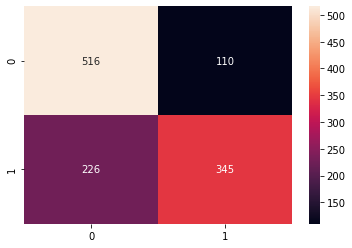

In [355]:
basepred = np.array(baselineresult.predict(df_test) > 0.5, dtype=float)
confmatrix = np.histogram2d(y_dftest, basepred, bins=2)[0]
sns.heatmap(confmatrix, annot = True, fmt='g')

In [367]:
basepred = np.array(baselineresult.predict(df_test) > 0.5, dtype=float)
redeyepred = np.array(redeyeresult.predict(df_test) > 0.5, dtype=float)
businesspred = np.array(businessresult.predict(df_test) > 0.5, dtype=float)
frequentpred = np.array(frequentresult.predict(df_test) > 0.5, dtype=float)
shortpred = np.array(shortresult.predict(df_test) > 0.5, dtype=float)
longpred = np.array(longresult.predict(df_test) > 0.5, dtype=float)

In [387]:
import statsmodels.formula.api  as smf


redeye=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    +price_diff
                    -legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window


                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    +seatB_class_Premium : seatA_class_ExitRow
                    -seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('time_redeye == 1'))

#Does not exist: +colB_categorical_Middle : colA_categorical_Aisle

redeyeresult=redeye.fit( maxiter = 500)

print(redeyeresult.summary2())

Optimization terminated successfully.
         Current function value: 0.487100
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.289      
Dependent Variable:            choice_binary             AIC:                       2382.6910  
Date:                          2021-05-27 18:02          BIC:                       2469.5328  
No. Observations:              2415                      Log-Likelihood:            -1176.3    
Df Model:                      14                        LL-Null:                   -1655.1    
Df Residuals:                  2400                      LLR p-value:               1.9484e-195
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [320]:
import statsmodels.formula.api  as smf


business=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window


                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('flyertype_business == 1'))
                    
#Does not exist: +colB_categorical_Middle : colA_categorical_Aisle
    
businessresult=business.fit( maxiter = 500)

print(businessresult.summary2())

Optimization terminated successfully.
         Current function value: 0.488866
         Iterations 8
                                        Results: Logit
Model:                        Logit                      Pseudo R-squared:           0.293     
Dependent Variable:           choice_binary              AIC:                        902.0931  
Date:                         2021-05-27 16:47           BIC:                        969.2330  
No. Observations:             894                        Log-Likelihood:             -437.05   
Df Model:                     13                         LL-Null:                    -617.79   
Df Residuals:                 880                        LLR p-value:                2.9630e-69
Converged:                    1.0000                     Scale:                      1.0000    
No. Iterations:               8.0000                                                           
---------------------------------------------------------------------------

In [327]:
import statsmodels.formula.api  as smf


frequent=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    +price_diff_rel 
                    
                    +colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window

                    +seatB_class_Economy : seatA_class_Bathroom 
                    -seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('flyerfreq_frequent == 1'))

#Does not exist: +colB_categorical_Middle : colA_categorical_Aisle                    

frequentresult=frequent.fit( maxiter = 500)

print(frequentresult.summary2())

Optimization terminated successfully.
         Current function value: 0.494151
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.285      
Dependent Variable:            choice_binary             AIC:                       2194.3348  
Date:                          2021-05-27 16:48          BIC:                       2268.3501  
No. Observations:              2194                      Log-Likelihood:            -1084.2    
Df Model:                      12                        LL-Null:                   -1517.0    
Df Residuals:                  2181                      LLR p-value:               1.3128e-177
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [339]:
import statsmodels.formula.api  as smf


short=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    -price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window

                    -seatB_class_Economy : seatA_class_Bathroom 
                    -seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    -seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('hours_short == 1'))

 #Does not exist: +colB_categorical_Middle : colA_categorical_Aisle                   

shortresult=short.fit( maxiter = 500)

print(shortresult.summary2())

Optimization terminated successfully.
         Current function value: 0.470419
         Iterations 7
                                        Results: Logit
Model:                        Logit                      Pseudo R-squared:           0.313     
Dependent Variable:           choice_binary              AIC:                        763.9663  
Date:                         2021-05-27 16:50           BIC:                        801.3930  
No. Observations:             795                        Log-Likelihood:             -373.98   
Df Model:                     7                          LL-Null:                    -544.10   
Df Residuals:                 787                        LLR p-value:                1.5200e-69
Converged:                    1.0000                     Scale:                      1.0000    
No. Iterations:               7.0000                                                           
---------------------------------------------------------------------------

In [347]:
import statsmodels.formula.api  as smf


long=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    -rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    
                    
                    -seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    +seatB_class_Premium : seatA_class_ExitRow
                    -seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('hours_long == 1'))
                    

longresult=long.fit( maxiter = 500)

print(longresult.summary2())

Optimization terminated successfully.
         Current function value: 0.516393
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.251      
Dependent Variable:            choice_binary             AIC:                       1565.9504  
Date:                          2021-05-27 16:52          BIC:                       1629.6529  
No. Observations:              1493                      Log-Likelihood:            -770.98    
Df Model:                      11                        LL-Null:                   -1029.6    
Df Residuals:                  1481                      LLR p-value:               6.5116e-104
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [421]:
male=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    -rowdiff
                    
                    +price_diff 
                    -legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    
                    
                    -seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    +seatB_class_Premium : seatA_class_ExitRow
                    -seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('gender_Male == 1'))
                    

maleresult=male.fit( maxiter = 500)

print(maleresult.summary2())

Optimization terminated successfully.
         Current function value: 0.499452
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.270      
Dependent Variable:            choice_binary             AIC:                       2571.2083  
Date:                          2021-05-27 19:16          BIC:                       2647.1681  
No. Observations:              2548                      Log-Likelihood:            -1272.6    
Df Model:                      12                        LL-Null:                   -1742.8    
Df Residuals:                  2535                      LLR p-value:               1.1570e-193
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [429]:
female=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    +legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    
                    
                    +seatB_class_Economy : seatA_class_Bathroom 
                    -seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('gender_Female == 1'))
                    

femaleresult=female.fit( maxiter = 500)

print(femaleresult.summary2())

Optimization terminated successfully.
         Current function value: 0.505168
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.270      
Dependent Variable:            choice_binary             AIC:                       2273.9982  
Date:                          2021-05-27 19:17          BIC:                       2348.1959  
No. Observations:              2225                      Log-Likelihood:            -1124.0    
Df Model:                      12                        LL-Null:                   -1540.0    
Df Residuals:                  2212                      LLR p-value:               2.1552e-170
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [446]:
tall=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    -price_diff_rel 
                    
                    +colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    
                    
                    +seatB_class_Economy : seatA_class_Bathroom 
                    -seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    -seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('height_cat_tall == 1'))
                    

tallresult=tall.fit( maxiter = 500)

print(tallresult.summary2())

Optimization terminated successfully.
         Current function value: 0.502932
         Iterations 8
                                        Results: Logit
Model:                        Logit                      Pseudo R-squared:           0.265     
Dependent Variable:           choice_binary              AIC:                        972.5414  
Date:                         2021-05-27 19:22           BIC:                        1025.9044 
No. Observations:             945                        Log-Likelihood:             -475.27   
Df Model:                     10                         LL-Null:                    -646.46   
Df Residuals:                 934                        LLR p-value:                1.6424e-67
Converged:                    1.0000                     Scale:                      1.0000    
No. Iterations:               8.0000                                                           
---------------------------------------------------------------------------

In [471]:
underthirty=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    +legroom_diff
                    +price_diff_rel 
                    
                    -colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    -colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    
                    
                    -seatB_class_Economy : seatA_class_Bathroom 
                    -seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('age_cat_Under30 == 1'))
                    

underthirtyresult=underthirty.fit( maxiter = 500)

print(underthirtyresult.summary2())

Optimization terminated successfully.
         Current function value: 0.474621
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.305      
Dependent Variable:            choice_binary             AIC:                       1564.6198  
Date:                          2021-05-27 19:36          BIC:                       1629.3242  
No. Observations:              1623                      Log-Likelihood:            -770.31    
Df Model:                      11                        LL-Null:                   -1109.1    
Df Residuals:                  1611                      LLR p-value:               3.6134e-138
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [477]:
overthirty=smf.logit("""
                    choice_binary ~ 
                    
                    
                    +rowA_
                    -rowB_ 
                    +rowdiff
                    
                    -price_diff 
                    -legroom_diff
                    +price_diff_rel 
                    
                    +colB_categorical_Window : colA_categorical_Aisle
                    +colB_categorical_Window : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Middle 
                    +colB_categorical_Aisle : colA_categorical_Window 
                    +colB_categorical_Middle : colA_categorical_Window
                    
                    
                    +seatB_class_Economy : seatA_class_Bathroom 
                    +seatB_class_Bathroom : seatA_class_Economy 
                    -seatB_class_ExitRow : seatA_class_Economy
                    -seatB_class_Premium : seatA_class_ExitRow
                    +seatB_class_Economy : seatA_class_First
                    +seatB_class_Economy : seatA_class_Premium 
                    +seatB_class_First : seatA_class_Premium

                    +plane_sideA_Left : plane_sideB_Right                                      

                    """, data = df_train.query('age_cat_Over30 == 1'))
                    

overthirtyresult=overthirty.fit( maxiter = 500)

print(overthirtyresult.summary2())

Optimization terminated successfully.
         Current function value: 0.517200
         Iterations 7
                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.251      
Dependent Variable:            choice_binary             AIC:                       3303.8741  
Date:                          2021-05-27 19:37          BIC:                       3394.7728  
No. Observations:              3165                      Log-Likelihood:            -1636.9    
Df Model:                      14                        LL-Null:                   -2186.6    
Df Residuals:                  3150                      LLR p-value:               7.1789e-226
Converged:                     1.0000                    Scale:                     1.0000     
No. Iterations:                7.0000                                                          
---------------------------------------------------------------------------

In [379]:
guessaccuracy = y_dftest.sum()/y_dftest.count()
baselineaccuracy = accuracy_score(y_dftest, basepred)
redeyeaccuracy = accuracy_score(y_dftest,redeyepred)
businessaccuracy = accuracy_score(y_dftest,businesspred)
frequentaccuracy = accuracy_score(y_dftest,frequentpred)
shortaccuracy = accuracy_score(y_dftest,shortpred)
longaccuracy = accuracy_score(y_dftest,longpred)

baself1 = f1_score(y_dftest, basepred)
redeyef1 = f1_score(y_dftest,redeyepred)
businessf1 = f1_score(y_dftest,businesspred)
frequentf1 = f1_score(y_dftest,frequentpred)
shortf1 = f1_score(y_dftest,shortpred)
longf1 = f1_score(y_dftest,longpred)

acc = { 'model': ['Guess','basemodel','redeye','Business', 'Frequent', 'Short Trips','Long Trips'],
        'accuracy': [guessaccuracy, baselineaccuracy, redeyeaccuracy, businessaccuracy, frequentaccuracy, shortaccuracy, longaccuracy],
        'f1': [0, basef1, redeyef1, businessf1, frequentf1, shortf1, longf1] }

accuracy = pd.DataFrame(acc)
accuracy


,model,accuracy,f1
0,Guess,0.47703,0.00000
1,basemodel,0.71930,0.67251
2,redeye,0.73684,0.68342
3,Business,0.73350,0.68259
4,Frequent,0.71596,0.67803
5,Short Trips,0.71846,0.70203
6,Long Trips,0.72598,0.68582


In [479]:
feature_names = baselineresult.params.index
basecoef = baselineresult.params.values
redeyecoef = redeyeresult.params.values

basecoefs = pd.DataFrame({
    'base' : baselineresult.params.index,
    'coef': baselineresult.params.values,
})

redeyecoefs = pd.DataFrame({
    'redeye' : redeyeresult.params.index,
    'coef': redeyeresult.params.values,
})

businesscoefs = pd.DataFrame({
    'redeye' : businessresult.params.index,
    'coef': businessresult.params.values,
})

frequentcoefs = pd.DataFrame({
    'redeye' : frequentresult.params.index,
    'coef': frequentresult.params.values,
})

shortcoefs = pd.DataFrame({
    'redeye' : shortresult.params.index,
    'coef': shortresult.params.values,
})

longcoefs = pd.DataFrame({
    'redeye' : longresult.params.index,
    'coef': longresult.params.values,
})

malecoefs = pd.DataFrame({
    'redeye' : maleresult.params.index,
    'coef': maleresult.params.values,
})

femalecoefs = pd.DataFrame({
    'redeye' : femaleresult.params.index,
    'coef': femaleresult.params.values,
})

tallcoefs = pd.DataFrame({
    'redeye' : tallresult.params.index,
    'coef': tallresult.params.values,
})

underthirtycoefs = pd.DataFrame({
    'redeye' : underthirtyresult.params.index,
    'coef': underthirtyresult.params.values,
})

overthirtycoefs = pd.DataFrame({
    'redeye' : overthirtyresult.params.index,
    'coef': overthirtyresult.params.values,
})

overthirtycoefs

,redeye,coef
0,Intercept,1.65885
1,rowA_,-0.13199
2,rowdiff,-0.03839
3,price_diff_rel,-1.56225
4,colB_categorical_Window:colA_categorical_Aisle,0.64678
5,colB_categorical_Window:colA_categorical_Middle,-2.82633
6,colB_categorical_Aisle:colA_categorical_Middle,-0.76170
7,colB_categorical_Aisle:colA_categorical_Window,0.63717
8,colB_categorical_Middle:colA_categorical_Window,2.63961
9,seatB_class_Economy:seatA_class_Bathroom,1.15055
